In [1]:
from __future__ import print_function, division
import choroplethNYC as cp
import pandas as pd
import urllib
import io
import os
import requests
import geopandas as gpd
import json
import fiona
from geopandas import GeoDataFrame
import pylab as pl
import shapely
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
with open('censusAPI.txt', 'r') as f:
    myAPI = f.readline()

## Part 1 - Accessing PUMA Data

In [3]:
urllib.urlretrieve("https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile", "Puma.zip")

('Puma.zip', <httplib.HTTPMessage instance at 0x7f66b687dc68>)

In [4]:
filename = "geo_export_eaa84a25-8102-40e0-9fde-2b5045f499e9.shp"
pumashp = gpd.GeoDataFrame.from_file(filename)

In [5]:
pumashp["puma"] = pumashp["puma"].astype(int)
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [6]:
pumashp.crs

{'init': u'epsg:4326'}

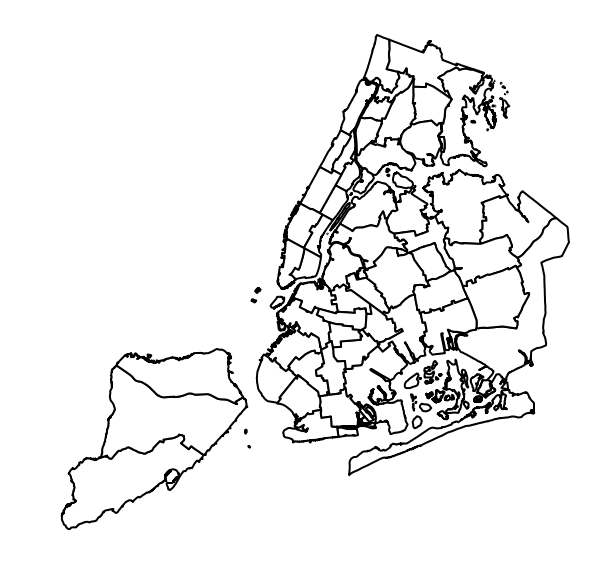

In [7]:
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);

Fig. 1 shows the 54 PUMA regions of New York City, each one containing at least 100,000 persons.

## Part 2 - Accessing American Fact Finder Data

In [8]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [9]:
affkeys = np.array(aff1y['variables'].keys())

In [10]:
[(k, aff1y['variables'][k]['label']) for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[(u'B28002_008E',
  u'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_008M',
  u'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_004MA',
  u'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_008MA',
  u'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_004E',
  u'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_004M',
  u'Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_007MA',
  u'Annotation of Ma

### Determining number of households per PUMA 

In [11]:
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{u'attributes': u'B28002_001M,B28002_001EA',
 u'concept': u'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 u'group': u'B28002',
 u'label': u'Estimate!!Total',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

In [12]:
urlHH = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
respHH = requests.request('GET', urlHH).content
pumaHH = pd.read_csv(io.StringIO(respHH.decode('utf-8').replace('[','').replace(']','')))

pumaHH.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


### Determining broadband access per PUMA

In [13]:
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{u'attributes': u'B28002_004M,B28002_004EA',
 u'concept': u'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 u'group': u'B28002',
 u'label': u'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

In [14]:
urlBB = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
respBB = requests.request('GET', urlBB).content
pumaBB = pd.read_csv(io.StringIO(respBB.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [15]:
pumaData = pd.merge(pumaBB, pumaHH, on='public use microdata area')
pumaData = pumaData.drop(['state_x', 'state_y', 'NAME_x', 'Unnamed: 4_x', 'Unnamed: 4_y'], axis=1)
pumaData['PercentBB'] = (pumaData['B28002_004E']/pumaData['B28002_001E']) * 100

In [16]:
pumaData.head()

,B28002_004E,public use microdata area,B28002_001E,NAME_y,PercentBB
0,32607,100,40479,"St. Lawrence County PUMA, New York",80.552879
1,50811,200,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",75.733321
2,41210,300,51614,"Warren & Washington Counties PUMA, New York",79.842678
3,36075,401,44300,Herkimer (North & Central) & Oneida (Outer) Co...,81.433409
4,47786,402,61146,Oneida County (Central)--Greater Utica & Rome ...,78.150656


### Importing Published AFF Data

In [17]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])
bbpc.drop(0, inplace=True)
bbpc['PUMA'] = bbpc['GCT_STUB.target-geo-id2'].astype(int)
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02,PUMA
1,01,74.7,0.5,1
2,0100100,70.9,2.5,100100
3,0100200,80.5,2.7,100200
4,0100301,87.0,2.8,100301
5,0100302,81.9,2.9,100302


In [18]:
bbpc["public use microdata area"] = bbpc.PUMA - 3600000

In [19]:
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02,PUMA,public use microdata area
1,01,74.7,0.5,1,-3599999
2,0100100,70.9,2.5,100100,-3499900
3,0100200,80.5,2.7,100200,-3499800
4,0100301,87.0,2.8,100301,-3499699
5,0100302,81.9,2.9,100302,-3499698


In [20]:
diff = pd.merge(pumaData, bbpc, on="public use microdata area")

In [21]:
diff["diff"] = np.abs(diff["PercentBB"] - diff["HC01"].astype(float))
diff.describe()

,B28002_004E,public use microdata area,B28002_001E,PercentBB,PUMA,diff
count,145.000000,145.000000,145.000000,145.000000,1.450000e+02,145.000000
mean,40603.862069,2826.827586,49717.613793,81.845478,3.602827e+06,0.026217
std,11787.178809,1210.054822,13579.838124,7.063369,1.210055e+03,0.014480
min,17925.000000,100.000000,28984.000000,54.932945,3.600100e+06,0.000178
25%,32736.000000,1900.000000,40473.000000,77.770257,3.601900e+06,0.012252
50%,37294.000000,3208.000000,46654.000000,82.826141,3.603208e+06,0.027230
75%,44681.000000,3809.000000,56295.000000,87.305077,3.603809e+06,0.039090
max,102520.000000,4114.000000,111507.000000,93.404143,3.604114e+06,0.049872


In [22]:
diff = diff.rename(columns={'public use microdata area': 'puma'})
diff.head()

,B28002_004E,puma,B28002_001E,NAME_y,PercentBB,GCT_STUB.target-geo-id2,HC01,HC02,PUMA,diff
0,32607,100,40479,"St. Lawrence County PUMA, New York",80.552879,3600100,80.6,2.6,3600100,0.047121
1,50811,200,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",75.733321,3600200,75.7,2.2,3600200,0.033321
2,41210,300,51614,"Warren & Washington Counties PUMA, New York",79.842678,3600300,79.8,2.6,3600300,0.042678
3,36075,401,44300,Herkimer (North & Central) & Oneida (Outer) Co...,81.433409,3600401,81.4,2.4,3600401,0.033409
4,47786,402,61146,Oneida County (Central)--Greater Utica & Rome ...,78.150656,3600402,78.2,2.3,3600402,0.049344


## Part 3 - Merge and Plot

In [23]:
pumashape = pd.merge(pumashp, diff, on='puma')
pumashape.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,B28002_001E,NAME_y,PercentBB,GCT_STUB.target-geo-id2,HC01,HC02,PUMA,diff
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,42158,"NYC-Bronx Community District 8--Riverdale, Fie...",84.275820,3603701,84.3,2.6,3603701,0.024180
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,49817,"NYC-Bronx Community District 12--Wakefield, Wi...",68.310015,3603702,68.3,3.7,3603702,0.010015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,44329,"NYC-Bronx Community District 10--Co-op City, P...",82.826141,3603703,82.8,3.2,3603703,0.026141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,44476,NYC-Bronx Community District 11--Pelham Parkwa...,72.553737,3603704,72.6,3.6,3603704,0.046263
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,58706,"NYC-Bronx Community District 3 & 6--Belmont, C...",69.425612,3603705,69.4,3.2,3603705,0.025612


(<matplotlib.figure.Figure at 0x7f666389d7d0>,
 <matplotlib.colorbar.Colorbar at 0x7f6663773150>)

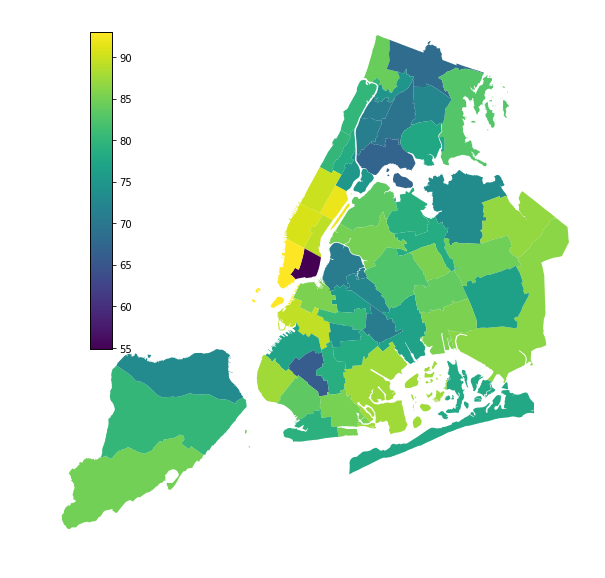

In [24]:
cp.choroplethNYC(pumashape, column='PercentBB')

### Fig. 2 showcases the percentage of households per PUMA with Broadband Internet Access 

## Part 4 - LinkNYC Data

In [25]:
linkNYC = pd.read_csv('https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv')

In [26]:
linkNYC = linkNYC.set_index('Unnamed: 0')
linkNYC.head()

,link_site,longitude,date_link_,latitude
Unnamed: 0,,,,
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [27]:
linkNYC.shape

(1414, 4)

### Create lonlat and geometry values

In [28]:
linkNYC['lonlat'] = zip(linkNYC['longitude'], linkNYC['latitude'])

In [29]:
geometry = [shapely.geometry.Point(xy) for xy in linkNYC['lonlat']]
crs = {'init': 'epsg:4326'}
linkNYCgdf = GeoDataFrame(linkNYC, crs=crs, geometry=geometry)

In [30]:
linkNYCgdf.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
Unnamed: 0,,,,,,
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


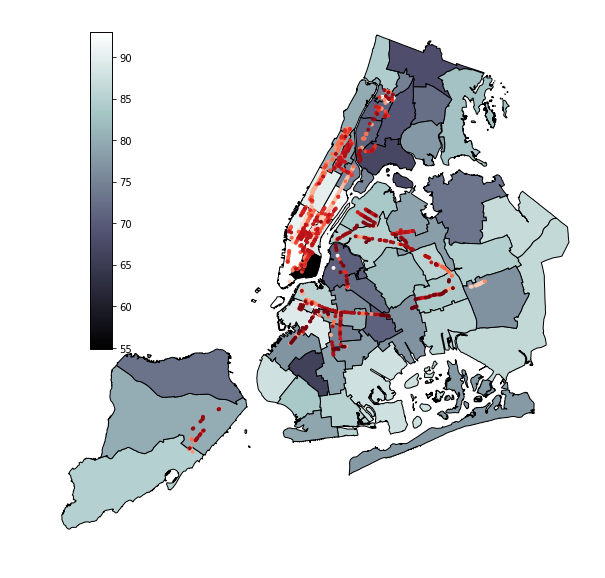

In [31]:
fig, ax, cb = cp.choroplethNYC(pumashape, column='PercentBB', cmap='bone', cb=True, edgecolor='Black');
linkNYCgdf.plot(ax=ax, cmap='Reds', markersize=8);

### Fig. 3 shows the location of every LinkNYC mapped atop the percentage of broadband accessible households per PUMA

## Part 5 - Link locations per person

In [32]:
keyPop = 'B00001_001E'
urlPop = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
respPop = requests.request('GET', urlPop).content
pumaPop = pd.read_csv(io.StringIO(respPop.decode('utf-8').replace('[','').replace(']','')))
pumaPop['puma'] = pumaPop['public use microdata area'].astype(int)
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4,puma
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN,100
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,200
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN,300
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,401
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,402


In [33]:
len(pumashape)

55

In [34]:
popMerge = pd.merge(pumashape, pumaPop, on='puma')
popMerge = popMerge.rename(columns={'B28002_004E': 'BB Access', 'B28002_001E': 'Households',
                                   'B00001_001E': 'Population'})

In [35]:
popMerge = popMerge.drop(['NAME_y', 'GCT_STUB.target-geo-id2', 'HC02', 'PUMA', 'diff',
                         'NAME', 'state', 'public use microdata area'], inplace=False, axis=1)
popMerge['per100'] = popMerge['Population'] / 100

In [36]:
popMerge.head()

,puma,shape_leng,shape_area,geometry,BB Access,Households,PercentBB,HC01,Population,Unnamed: 4,per100
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,42158,84.275820,84.3,1517,NaN,15.17
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,49817,68.310015,68.3,1959,NaN,19.59
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,44329,82.826141,82.8,1305,NaN,13.05
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,44476,72.553737,72.6,1882,NaN,18.82
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,58706,69.425612,69.4,2011,NaN,20.11


### Convert to 2263

In [37]:
linkNYCgdf.crs = {'init': 'epsg:4326'}

In [38]:
linkNYCgdf2263 = linkNYCgdf.to_crs(epsg='2263')

In [39]:
popMergeGdf2263 = popMerge.to_crs(epsg='2263')

In [40]:
linkpp = gpd.sjoin(linkNYCgdf2263, popMergeGdf2263)

In [41]:
linkpp.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry,index_right,puma,shape_leng,shape_area,BB Access,Households,PercentBB,HC01,Population,Unnamed: 4,per100
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (1000196.411360609 194918.1045344363),23,4001,74076.370458,1.149292e+08,46643,66037,70.631616,70.6,2428,NaN,24.28
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (1000284.976955119 194872.4991186759),23,4001,74076.370458,1.149292e+08,46643,66037,70.631616,70.6,2428,NaN,24.28
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (1000265.48686938 195013.900946364),23,4001,74076.370458,1.149292e+08,46643,66037,70.631616,70.6,2428,NaN,24.28
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (1000076.658138533 196154.157733508),23,4001,74076.370458,1.149292e+08,46643,66037,70.631616,70.6,2428,NaN,24.28
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (997155.0239397929 204558.4761382252),23,4001,74076.370458,1.149292e+08,46643,66037,70.631616,70.6,2428,NaN,24.28


In [42]:
linkCount = linkpp.groupby('puma')[['link_site']].count()
linkCount.head()

,link_site
puma,
3701,1
3705,1
3706,20
3707,29
3708,19


In [43]:
linkCount.reset_index(level=0, inplace=True)
linkCount.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [44]:
pumashplc = pd.merge(linkCount, popMerge, on='puma', how='outer')
pumashplc.head()

,puma,link_site,shape_leng,shape_area,geometry,BB Access,Households,PercentBB,HC01,Population,Unnamed: 4,per100
0,3701.0,1.0,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,42158,84.275820,84.3,1517,NaN,15.17
1,3705.0,1.0,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,58706,69.425612,69.4,2011,NaN,20.11
2,3706.0,20.0,51799.404764,4.388687e+07,POLYGON ((-73.91328437051338 40.85961860183316...,34391,46018,74.733800,74.7,1274,NaN,12.74
3,3707.0,29.0,37347.926177,4.228113e+07,POLYGON ((-73.91328437051338 40.85961860183316...,32926,46654,70.574870,70.6,1548,NaN,15.48
4,3708.0,19.0,34853.551314,5.589653e+07,"POLYGON ((-73.92478318783078 40.8447526648105,...",35788,50192,71.302200,71.3,1462,NaN,14.62


In [45]:
pumashplc['linkNYCp100p'] = pumashplc['link_site'] / pumashplc['per100']

In [46]:
pumashplc.head()

,puma,link_site,shape_leng,shape_area,geometry,BB Access,Households,PercentBB,HC01,Population,Unnamed: 4,per100,linkNYCp100p
0,3701.0,1.0,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,42158,84.275820,84.3,1517,NaN,15.17,0.065920
1,3705.0,1.0,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,58706,69.425612,69.4,2011,NaN,20.11,0.049727
2,3706.0,20.0,51799.404764,4.388687e+07,POLYGON ((-73.91328437051338 40.85961860183316...,34391,46018,74.733800,74.7,1274,NaN,12.74,1.569859
3,3707.0,29.0,37347.926177,4.228113e+07,POLYGON ((-73.91328437051338 40.85961860183316...,32926,46654,70.574870,70.6,1548,NaN,15.48,1.873385
4,3708.0,19.0,34853.551314,5.589653e+07,"POLYGON ((-73.92478318783078 40.8447526648105,...",35788,50192,71.302200,71.3,1462,NaN,14.62,1.299590


In [47]:
pumashplc['linkNYCp100p'].describe()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

### Plot the end result

In [48]:
pumashplc = GeoDataFrame(pumashplc)

In [49]:
pumashplc.fillna(0, inplace=True)

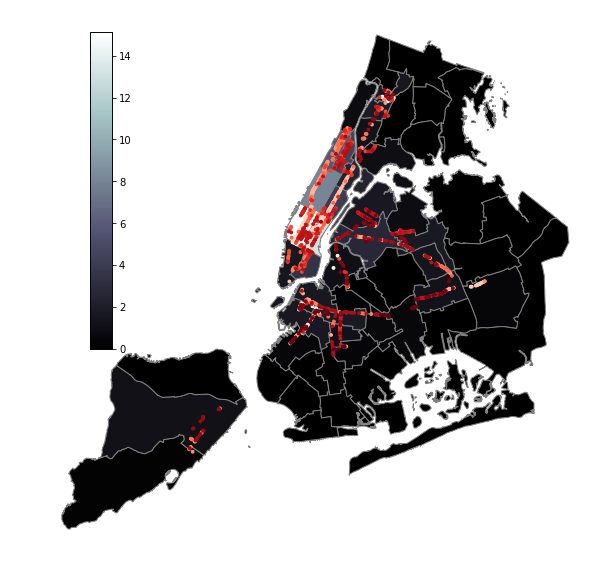

In [50]:
fig, ax, cb = cp.choroplethNYC(pumashplc, column='linkNYCp100p', cmap='bone', cb=True, edgecolor='grey');
linkNYCgdf.plot(ax=ax, cmap='Reds', markersize=8);

### Fig. 4 shows the location of every LinkNYC mapped atop a choropleth showcasing the number of stations per 100 persons per PUMA